In [1]:
import shutil
from autumn.projects.sm_covid2.common_school.runner_tools import INCLUDED_COUNTRIES
import pandas as pd
from pathlib import Path
from autumn.projects.sm_covid2.common_school.output_plots import multicountry as mc
from matplotlib import pyplot as plt 

from importlib import reload


full_iso3_list = list(INCLUDED_COUNTRIES['all'].keys())

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
c:\Users\rrag0004\.conda\envs\summer2\lib\site-packages\summer\runner\vectorized_runner.py:363: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_strain_infection_values(


In [10]:
# analysis_folder = Path.cwd() / "33489767_test_full_analysis_24Jan2024_main"
# analysis_folder = Path.cwd() /"33618782_test_full_analysis_24Jan2024_increased_hh_contacts"
analysis_folder = Path.cwd() /"33608845_test_full_analysis_24Jan2024_no_google_mobility"

common_dir = analysis_folder / "COMMON_DIRECTORY"
common_dir.mkdir(exist_ok=True)

### Move files to common folder

In [ ]:
to_move = {
    "r_hats": "mc_outputs/r_hats.jpg",
    "mcmc_traces_postburnin": "mc_outputs/mc_traces_postburnin.jpg",
    "optimal_fits": "optimal_fits.png",
}

for folder_name, file in to_move.items():
    folder = common_dir / folder_name
    folder.mkdir(exist_ok=True)

    for iso3 in full_iso3_list:
        src = analysis_folder / iso3 / file 
        if Path.exists(src):
            dst = folder / f"{src.stem}_{iso3}{src.suffix}" 
            shutil.copy(src, dst)

### Combine PDF files

In [11]:
from pypdf import PdfMerger

pdf_paths = []
for iso3 in full_iso3_list:
    pdf_path = analysis_folder / iso3 / f"highlights_{iso3}.pdf"
    if Path.exists(pdf_path):
        pdf_paths.append(pdf_path)

merger = PdfMerger()

for pdf in pdf_paths:
    merger.append(pdf)

merger.write(common_dir / "multi_highlights.pdf")
merger.close()

### Make multi-country figures

In [4]:
FILE_FORMATS = ["png", "pdf"]

In [12]:
diff_quantiles_dfs = {}
for iso3 in full_iso3_list:
    diff_quantiles_path = analysis_folder / iso3 / "diff_quantiles_df.parquet"
    if Path.exists(diff_quantiles_path):
        diff_quantiles_dfs[iso3] = pd.read_parquet(diff_quantiles_path)

In [13]:
fig = mc.plot_multic_relative_outputs(diff_quantiles_dfs)
plt.close()
for file_format in FILE_FORMATS:
    fig.savefig(common_dir / f"relative_outputs.{file_format}")

In [16]:
# RUN THIS CELL TWICE TO AVOID ANY WARNING TEXT SHOWING UP IN FIRST FIGURE
(common_dir / "maps").mkdir(exist_ok=True)
for i, output in enumerate(["cases_averted_relative", "deaths_averted_relative", "delta_hospital_peak_relative"]):  
    panel = ["A", "B", "C"][i]
    fig = mc.plot_relative_map_with_bins(diff_quantiles_dfs, output, panel)
    plt.close()
    for file_format in FILE_FORMATS:
        fig.write_image(common_dir / "maps" / f"map_{output}.{file_format}")

# Then combine the three figures using Nitro Pro
# Finally print to pdf from Nitro, using the custom Page Format called MapFigure

In [ ]:
def print_main_result_text(diff_quantiles_dfs):
    n_countries = len(diff_quantiles_dfs)

    n_pos_effects = {}
    perc_pos_effects = {}
    for q in [0.5, 0.975]:
        n_pos_effects[q] = {}
        perc_pos_effects[q] = {}
        for output in ["cases_averted", "deaths_averted", "delta_hospital_peak"]:
            n_pos_effects[q][output] = len([iso3 for iso3 in diff_quantiles_dfs if diff_quantiles_dfs[iso3][output][q] < 0.])
            perc_pos_effects[q][output] = int(100. * n_pos_effects[q][output] / n_countries)

    text = f"Based on our median estimates, school closures were associated with a beneficial effect on infections in {n_pos_effects[0.5]['cases_averted']} ({perc_pos_effects[0.5]['cases_averted']}%) countries, on deaths in {n_pos_effects[0.5]['deaths_averted']} ({perc_pos_effects[0.5]['deaths_averted']}%) countries, and on peak hospital occupancy in {n_pos_effects[0.5]['delta_hospital_peak']} ({perc_pos_effects[0.5]['delta_hospital_peak']}%) countries (Figure 1)."
    
    text += " However, the 95% credible intervals (95-CI) around our estimates for the three disease indicators were wide for most countries, such that even the direction of the effect was difficult to evaluate with certainty."

    text += f" Only {n_pos_effects[.975]['cases_averted']} ({perc_pos_effects[.975]['cases_averted']}%) countries were associated with a 95-CI entirely consistent with a positive effect of school closures on infections,"
    text += f" whereas {n_pos_effects[.975]['deaths_averted']} ({perc_pos_effects[.975]['deaths_averted']}%) countries had a 95-CI suggesting a positive effect on deaths,"
    text += f" and {n_pos_effects[.975]['delta_hospital_peak']} ({perc_pos_effects[.975]['delta_hospital_peak']}%) had a 95-CI suggesting a positive effect on peak hospital occupancy."

    print(text)


print_main_result_text(diff_quantiles_dfs)

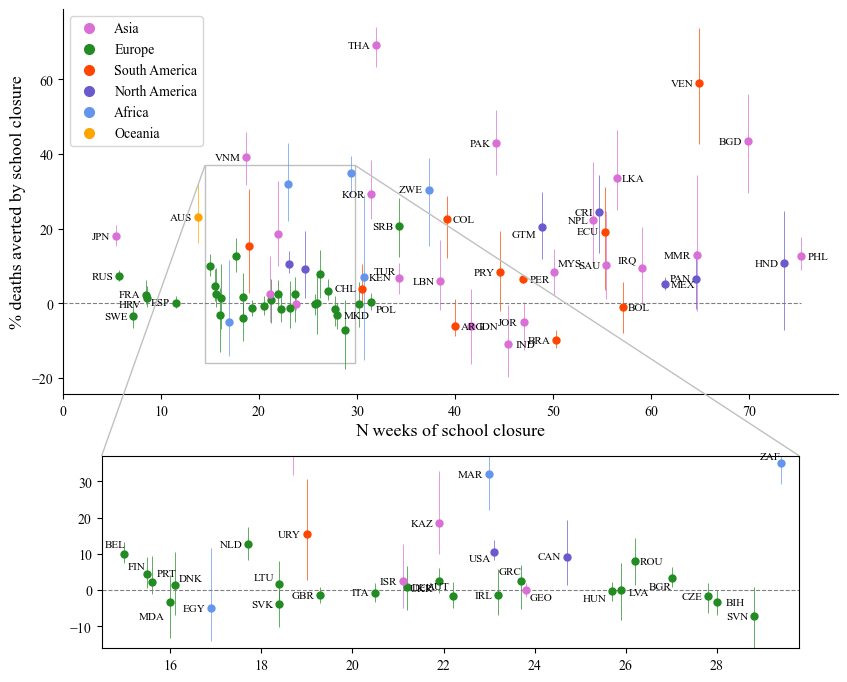

In [17]:
# MAKE ICER-LIKE PLOT

reload(mc)
for output in ["deaths_averted_relative"]: # ["cases_averted_relative", "deaths_averted_relative", "delta_hospital_peak_relative"]:
    fig = mc.make_icer_like_plot(diff_quantiles_dfs, output)
    for file_format in ["png", "pdf"]:  
        fig.savefig(common_dir / f"icer_{output}.{file_format}", bbox_inches='tight')